In [ ]:
# Installing the Backtrader library
!pip install backtrader

     |████████████████████████████████| 419kB 3.0MB/s 


In [ ]:
# Importing the required packages
from __future__ import (absolute_import, division, print_function, unicode_literals)

import warnings
warnings.filterwarnings('ignore')

import datetime  # For datetime information
import os.path   # To manage paths
import sys       # To find out the script name (in argv[0])

import backtrader as bt  # Importing the Backtrader library

In [ ]:
# Coding the strategy for MACD Indicator

class MACD_strategy(bt.Strategy):
  params=(('fast_LBP',14), ('slow_LBP',26), ('BBands_LBP',20))

  def log(self, txt, dt=None):
    dt = dt or self.datas[0].datetime.date(0)
    print('%s, %s' % (dt.isoformat(), txt)) 

  def __init__(self):
    self.dataclose = self.datas[0].close
    self.fast_EMA =  bt.indicators.ExponentialMovingAverage(self.data, period=self.params.fast_LBP)
    self.slow_EMA = bt.indicators.ExponentialMovingAverage(self.data, period=self.params.slow_LBP)

    self.MACD_strategy = self.fast_EMA-self.slow_EMA
    self.bband = bt.indicators.BBands(self.datas[0], period=self.params.BBands_LBP)
    self.order = None
    self.inc_ = None
    self.dec_ = None 

  def notify_order(self, order):
    if order.status in [order.Submitted, order.Accepted]:
      return
    if order.status in [order.Completed]:
      if order.isbuy():
        self.log('BUY EXECUTED, %.2f' % order.executed.price)
      elif order.issell():
        self.log('SELL EXECUTED, %.2f' % order.executed.price)

      self.bar_executed = len(self)
    elif order.status in [order.Canceled, order.Margin, order.Rejected]:
      self.log('Order Canceled/Margin/Rejected')

    self.order = None
    
  def next(self):
    if not self.order and not self.position:
      if self.MACD_strategy > 0:
        self.log('LONG -BUY, %.2f' % self.dataclose[0])
        self.inc_=True
        self.order = self.buy()
      elif self.MACD_strategy < 0:
        self.log('SHORT-SELL, %.2f' % self.dataclose[0])
        self.dec_=True
        self.order = self.sell()

    elif not self.order and  self.position :
      if self.MACD_strategy > 0 and self.dec_:
        self.log('BUY, %.2f' % self.dataclose[0])
        self.dec_=None
        self.order = self.buy()
      elif self.MACD_strategy < 0 and self.inc_:
        self.log('SELL, %.2f' % self.dataclose[0])
        self.inc_=None
        self.order = self.sell()
      if self.dataclose[0] > self.bband.lines.top and self.inc_ :
        self.log('SELL, %.2f' % self.dataclose[0])
        self.inc_=None
        self.order = self.sell()
      elif self.dataclose[0] < self.bband.lines.bot and  self.dec_:
        self.log('BUY, %.2f' % self.dataclose[0])
        self.dec_=None
        self.order = self.buy()

Starting Portfolio Value: 10000.00
2018-02-07, SHORT-SELL, 38.45
2018-02-08, SELL EXECUTED, 38.63
2018-02-27, BUY, 43.17
2018-02-28, BUY EXECUTED, 43.38
2018-02-28, LONG -BUY, 43.10
2018-03-01, BUY EXECUTED, 43.20
2018-03-23, SELL, 39.91
2018-03-26, SELL EXECUTED, 40.67
2018-03-26, SHORT-SELL, 41.81
2018-03-27, SELL EXECUTED, 42.03
2018-04-16, BUY, 42.54
2018-04-17, BUY EXECUTED, 42.71
2018-04-17, LONG -BUY, 43.13
2018-04-18, BUY EXECUTED, 43.03
2018-04-23, SELL, 39.98
2018-04-24, SELL EXECUTED, 40.09
2018-04-24, SHORT-SELL, 39.43
2018-04-25, SELL EXECUTED, 39.35
2018-05-04, BUY, 44.48
2018-05-07, BUY EXECUTED, 44.81
2018-05-07, LONG -BUY, 44.80
2018-05-08, BUY EXECUTED, 44.76
2018-06-04, SELL, 46.60
2018-06-05, SELL EXECUTED, 46.90
2018-06-05, LONG -BUY, 46.96
2018-06-06, BUY EXECUTED, 47.03
2018-06-06, SELL, 47.12
2018-06-07, SELL EXECUTED, 47.16
2018-06-07, LONG -BUY, 46.99
2018-06-08, BUY EXECUTED, 46.44
2018-06-27, SELL, 44.73
2018-06-28, SELL EXECUTED, 44.72
2018-06-28, SHORT-SEL

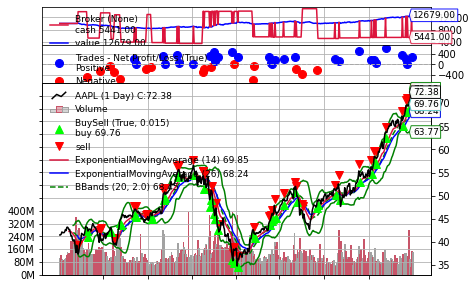

In [ ]:
# Implementing Moving Average Convergence Divergence - MACD

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(MACD_strategy) 

        # Create a Data Feed
    data = bt.feeds.YahooFinanceData(
        dataname='AAPL',
        fromdate=datetime.datetime(2018, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(2019, 12, 31),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Plot the result
    cerebro.plot(iplot=False)